For testing of function `cluster_dbscan` in `_map_regions`.

In [1]:
import numpy as np
from pathlib import Path
import s2spy.time
import s2spy.traintest
import s2spy.dimensionality
import s2spy.rgdr._map_regions
import xarray as xr

In [2]:
# prepare calendar
calendar = s2spy.time.AdventCalendar((8, 31), freq = "30d")
intervals = calendar.map_years(2010, 2012)

# path to raw data
path_to_data = Path("/home/yangliu/AI4S2S/proto/data")
# load data
xr_sst = xr.load_dataset(path_to_data / "sst_daily_1979-2018_5deg_Pacific_175_240E_25_50N.nc")
xr_tf = xr.load_dataset(path_to_data / "tf5_nc5_dendo_80d77.nc")

In [3]:
# resample precursor variable
calendar.map_to_data(xr_sst)
xr_sst_resample = calendar.resample(xr_sst)
xr_sst_resample

<xarray.Dataset>
Dimensions:      (anchor_year: 39, i_interval: 12, latitude: 5, longitude: 13)
Coordinates:
    index        (anchor_year, i_interval) int64 0 1 2 3 4 ... 464 465 466 467
    interval     (anchor_year, i_interval) object (1980-08-01, 1980-08-31] .....
  * latitude     (latitude) float64 47.5 42.5 37.5 32.5 27.5
  * longitude    (longitude) float64 177.5 182.5 187.5 ... 227.5 232.5 237.5
  * anchor_year  (anchor_year) int64 1980 1981 1982 1983 ... 2015 2016 2017 2018
  * i_interval   (i_interval) int64 0 1 2 3 4 5 6 7 8 9 10 11
    target       (i_interval) bool True False False False ... False False False
Data variables:
    sst          (anchor_year, i_interval, latitude, longitude) float64 284.2...

In [4]:
# resample target variable
calendar.map_to_data(xr_tf)
xr_tf_resample = calendar.resample(xr_tf)
xr_tf_resample

<xarray.Dataset>
Dimensions:      (anchor_year: 39, i_interval: 12, latitude: 41, longitude: 76, cluster: 6)
Coordinates:
    index        (anchor_year, i_interval) int64 0 1 2 3 4 ... 464 465 466 467
    interval     (anchor_year, i_interval) object (1980-08-01, 1980-08-31] .....
    tfreq        int64 5
    n_clusters   int64 6
  * longitude    (longitude) float64 225.0 226.0 227.0 ... 298.0 299.0 300.0
  * latitude     (latitude) float32 70.0 69.0 68.0 67.0 ... 33.0 32.0 31.0 30.0
    mask         (latitude, longitude) int8 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
  * cluster      (cluster) int64 1 2 3 4 5 6
  * anchor_year  (anchor_year) int64 1980 1981 1982 1983 ... 2015 2016 2017 2018
  * i_interval   (i_interval) int64 0 1 2 3 4 5 6 7 8 9 10 11
    target       (i_interval) bool True False False False ... False False False
Data variables:
    xrclustered  (anchor_year, i_interval, latitude, longitude) float32 nan ....
    ts           (anchor_year, i_interval, cluster) float64 0.1425 ... 0.372
    q75tail      (anchor_year, i_interval, cluster) float64 2.915 ... 3.208

In [5]:
# ts should be 1-d timeseries
ts = xr_tf_resample.ts.sel(cluster=3)
field = xr_sst_resample.sst

# we select data for testing
lag = 1 # we now calculate lag 0 correlation map
ts_target_period = ts[:,0] # Target: only August period (08-01, 08-31]
field_lag_1 = field[:,lag] # Precursor field lag 1 (07-02, 08-01]

In [6]:
# 2 calculate correlation
from scipy.stats import pearsonr

def corr_map(field: xr.DataArray, ts: np.ndarray):
    '''
    Calculate correlation map between field and ts, with field being a 3-d data variable
    of shape (time, latitude, longitude), ts is the 1-dimensional target timeseries. 
    Gridcell timeseries with any NaN, will be set to NaN completely as scipy.stats.pearsonr 
    can not handle a timeseries with any NaNs.
    '''
    # reshape field to (time, space)
    orig_shape = field.shape
    field = np.reshape(field.values, (orig_shape[0],-1))

    # To be implemented: Check NaNs and max_lag beforehand
    correlation = np.zeros(field.shape[1])

    p_values = np.zeros(field.shape[1])

    # scipy.stats.pearsonr can not handle a timeseries with any NaNs
    field_nans = np.array([np.isnan(field[:,i]).any() for i in range(correlation.size)])
    nonans_gc = np.arange(0, field_nans.size)[field_nans==False]

    for i in nonans_gc:
        correlation[i], p_values[i] = pearsonr(ts,field[:,i])
        # restore original nans
        correlation[field_nans] = np.nan

    correlation = correlation.reshape(orig_shape[1:])
    p_values = p_values.reshape(orig_shape[1:])
    return correlation, p_values

correlation, p_values = corr_map(field=field_lag_1, ts=ts_target_period)

In [7]:
map_correlation = xr.Dataset(
    {
        "correlation": (
            ("latitude", "longitude"),
            correlation
        ),
        "p_values": (
            ("latitude", "longitude"),
            p_values
        ),
    },
    coords={
        "latitude": field.latitude.values,
        "longitude": field.longitude.values,
    }
)

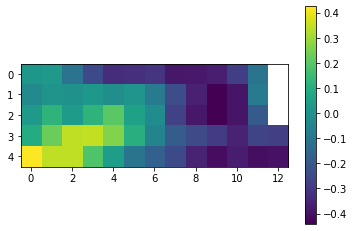

In [8]:
import matplotlib.pyplot as plt
plt.imshow(correlation) ; plt.colorbar()

In [11]:
labels = s2spy.rgdr._map_regions.cluster_dbscan(map_correlation, 0.05, 600, 3, -1)
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Not working!

In [12]:
from typing import Union
import numpy as np
import xarray as xr
from scipy.stats import pearsonr as _pearsonr

def _pearsonr_nan(x, y):
    """NaN friendly implementation of scipy.stats.pearsonr.
    """
    if np.any(np.isnan(x), np.isnan(y)):
        return np.nan, np.nan
    else:
        return _pearsonr(x, y)


def correlation(field: xr.DataArray, target: Union[xr.DataArray, np.ndarray],
                time_dim: str = 'time'):
    '''Calculate correlation maps.
    Args:
        field: Spatial data with a time dimension named `time_dim`, for which each
            location should have the Pearson correlation coefficient calculated with the
            target timeseries.
        target: Timeseries which has to be correlated with the spatial data. If it is
            a DataArray, it requires a dimension named `time_dim`
    Returns:
        r_coefficient: DataArray filled with the correlation coefficient for each
            non-time coordinate.
        p_value: DataArray filled with the two-tailed p-values for each computed
            correlation coefficient.
    '''
    return xr.apply_ufunc(_pearsonr_nan, field, target,
                          input_core_dims=[[time_dim], [time_dim]], vectorize=True,
                          output_core_dims=[[], []])

In [14]:
field_lag_1 = field_lag_1.rename({"anchor_year": "time"})
ts_target_period = ts_target_period.rename({"anchor_year": "time"})

In [15]:
r, p = correlation(field_lag_1, ts_target_period)

TypeError: only integer scalar arrays can be converted to a scalar index